Following tutorial from SHAP library: https://shap.readthedocs.io/en/latest/index.html 

In [5]:
!pip install shap

     |████████████████████████████████| 564 kB 7.2 MB/s 


# I. Compute SHAP values

## (1) Boston dataset

Below we train a linear regression model on the classic boston housing dataset. This dataset consists of 506 neighboorhood regions around Boston in 1978, where our goal is to predict the median home price (in thousands) in each neighboorhood from 14 different features:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000’s

In [3]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

LinearRegression()

### Examining the model coefficients

In [4]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


### A more complete picture using partial dependence plots

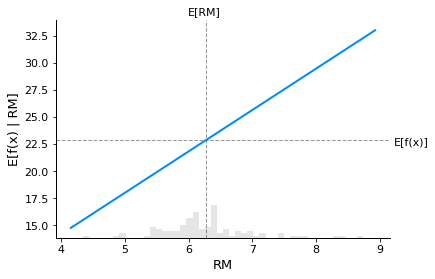

In [5]:
shap.plots.partial_dependence(
    "RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

The gray horizontal line in the plot above represents the expected value of the model when applied to the boston housing dataset. The vertical gray line represents the average value of the RM feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the RM feature to a given value) always passes through the interesection of the two gray expected value lines.

### Reading SHAP values from partial dependence plots

Permutation explainer: 507it [00:43,  9.30it/s]                         


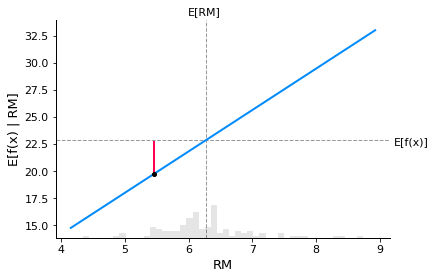

In [6]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

/!\ Q: How do we know from which value of the X-axis we compute the difference with the gray horizontal line?

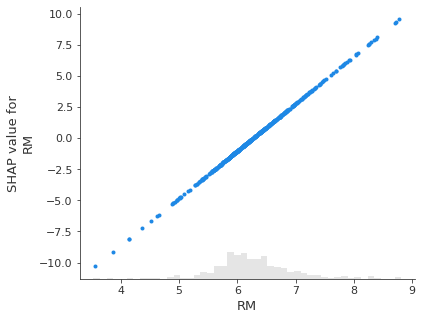

In [7]:
shap.plots.scatter(shap_values[:,"RM"])

### The additive nature of Shapley values

SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

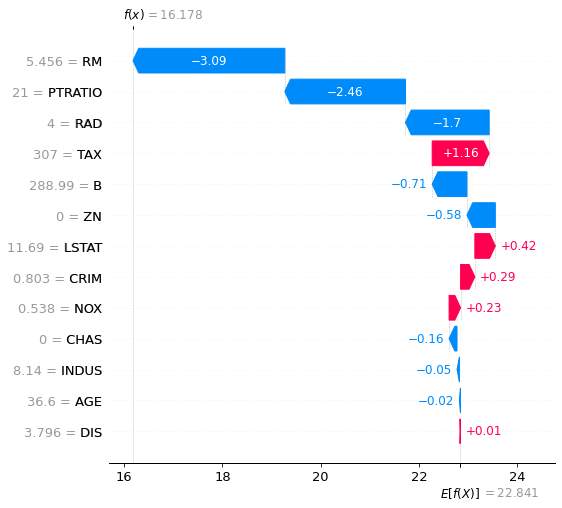

In [8]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

###  Explaining an additive regression model

The reason the partial dependence plots of linear models have such a close connection to SHAP values is because **each feature in the model is handled independently of every other feature (the effects are just added together)**. 

In [10]:
!pip install interpret

     |████████████████████████████████| 6.6 MB 5.2 MB/s 
     |████████████████████████████████| 5.8 MB 42.8 MB/s 
     |████████████████████████████████| 3.6 MB 56.3 MB/s 
     |████████████████████████████████| 9.6 MB 40.2 MB/s 
     |████████████████████████████████| 756 kB 50.6 MB/s 
     |████████████████████████████████| 275 kB 50.6 MB/s 
     |████████████████████████████████| 280 kB 47.2 MB/s 
     |████████████████████████████████| 131 kB 62.5 MB/s 
     |████████████████████████████████| 793 kB 52.7 MB/s 
     |████████████████████████████████| 251 kB 49.4 MB/s 
     |████████████████████████████████| 428 kB 42.3 MB/s 
     |████████████████████████████████| 130 kB 68.2 MB/s 
     |████████████████████████████████| 381 kB 64.1 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 357 kB 75.3 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 

Permutation explainer: 507it [01:18,  5.76it/s]


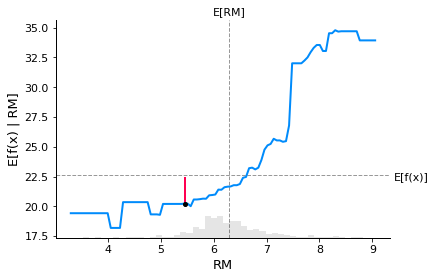

In [11]:
# fit a GAM model to the data
import interpret.glassbox # Glassbox vs backbox!! Seems to be a nice library!
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

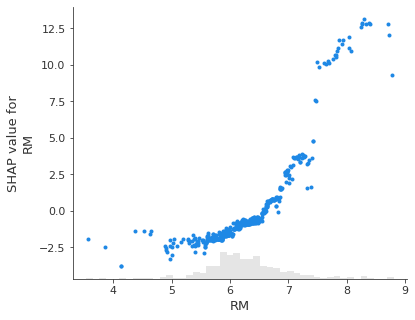

In [12]:
shap.plots.scatter(shap_values_ebm[:,"RM"])

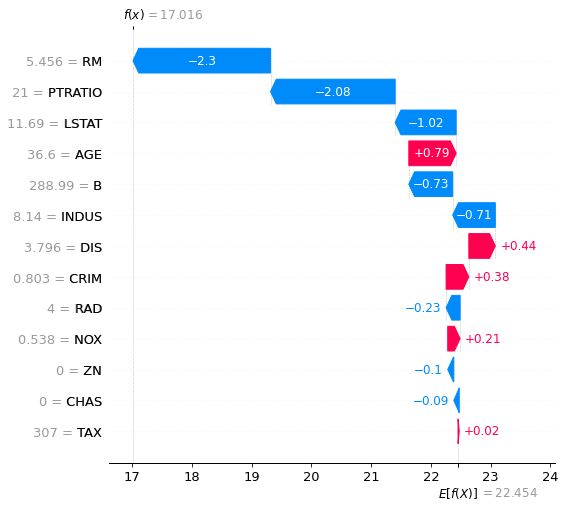

In [13]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)

If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

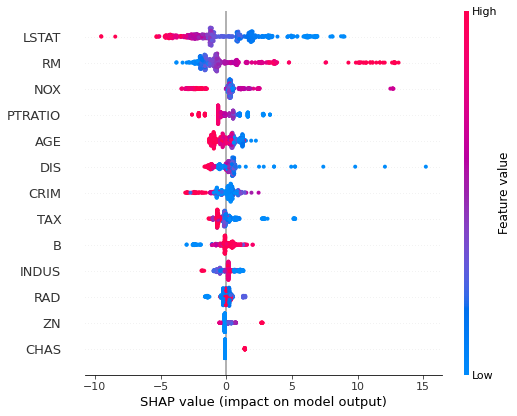

In [14]:
# interesting here: we do not need to select a specify instance!
shap.plots.beeswarm(shap_values_ebm, max_display=14)

### Explaining a non-additive boosted tree model

[13:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


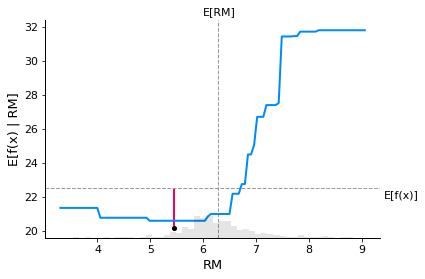

In [15]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_xgb.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

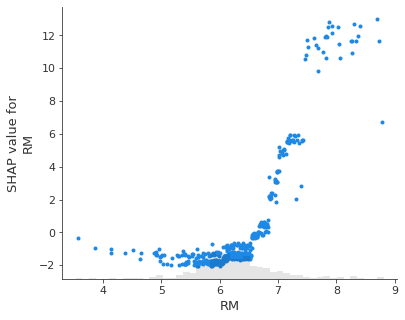

In [16]:
shap.plots.scatter(shap_values_xgb[:,"RM"])

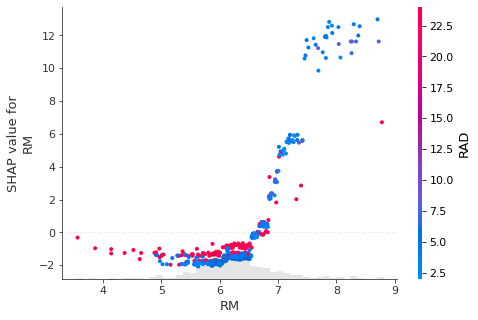

In [17]:
shap.plots.scatter(shap_values_xgb[:,"RM"], color=shap_values)

## (2) Adult census price dataset

### Explaining a linear logistic regression model

In [18]:
# a classic adult census dataset price dataset
X_adult,y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

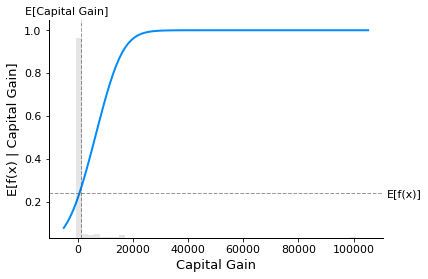

In [19]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

In [20]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [01:30,  9.82it/s]                          


### Explaining a non-additive boosted tree logistic regression model

In [21]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

 95%|=================== | 31048/32561 [00:23<00:01]       

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

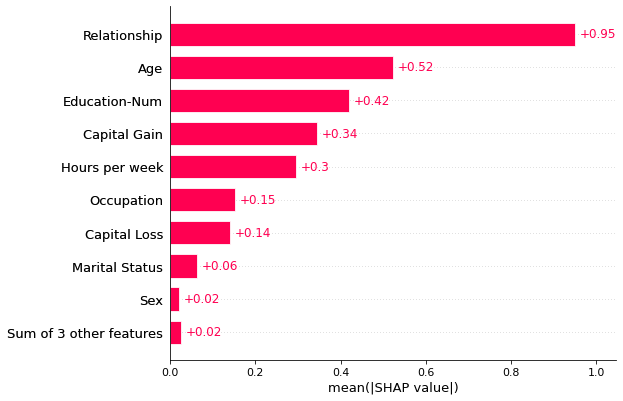

In [22]:
shap.plots.bar(shap_values)

But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrequent but high magnitude effects.

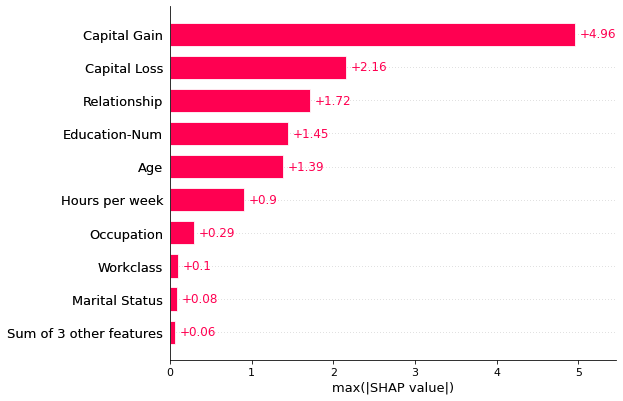

In [23]:
shap.plots.bar(shap_values.abs.max(0))

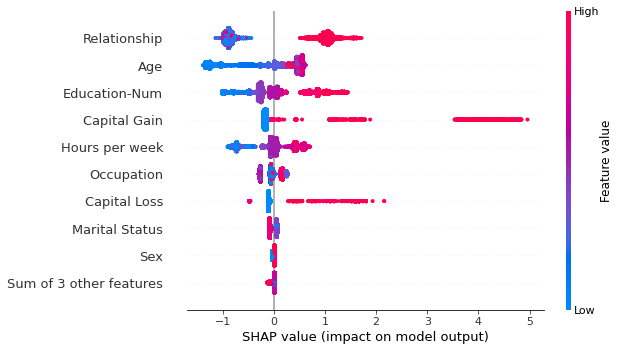

In [24]:
shap.plots.beeswarm(shap_values)

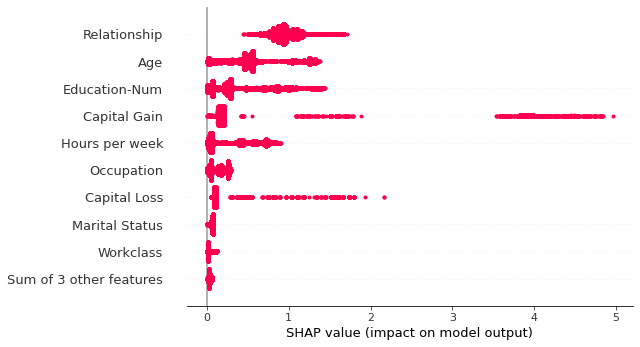

In [25]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

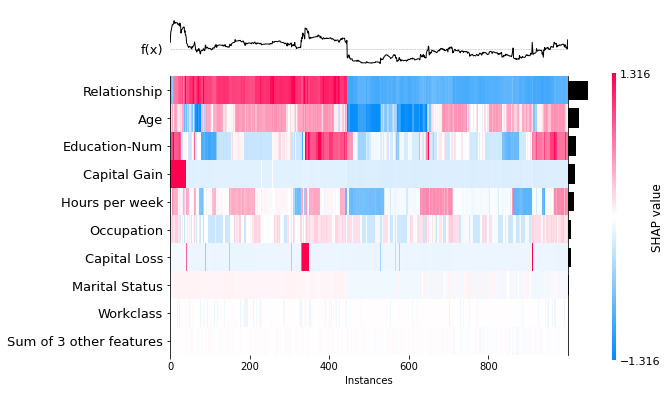

In [26]:
shap.plots.heatmap(shap_values[:1000])

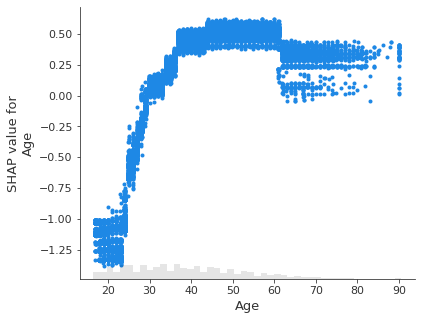

In [27]:
shap.plots.scatter(shap_values[:,"Age"])

### Dealing with correlated features

In [28]:
clustering = shap.utils.hclust(X_adult, y_adult)

[13:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 50%|█████     | 6/12 [00:00<?, ?it/s]

[13:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 67%|██████▋   | 8/12 [00:15<00:05,  1.50s/it]

[13:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 75%|███████▌  | 9/12 [00:18<00:07,  2.35s/it]

[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 83%|████████▎ | 10/12 [00:19<00:03,  1.78s/it]

[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 92%|█████████▏| 11/12 [00:20<00:01,  1.43s/it]

[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 12/12 [00:22<00:00,  1.51s/it]

[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

13it [00:23,  3.38s/it]

[13:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


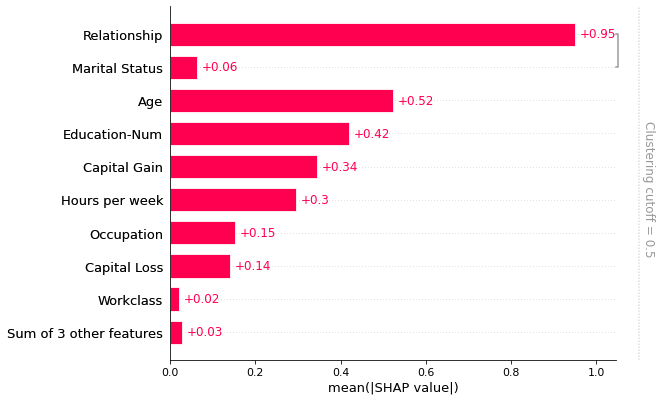

In [29]:
shap.plots.bar(shap_values, clustering=clustering)

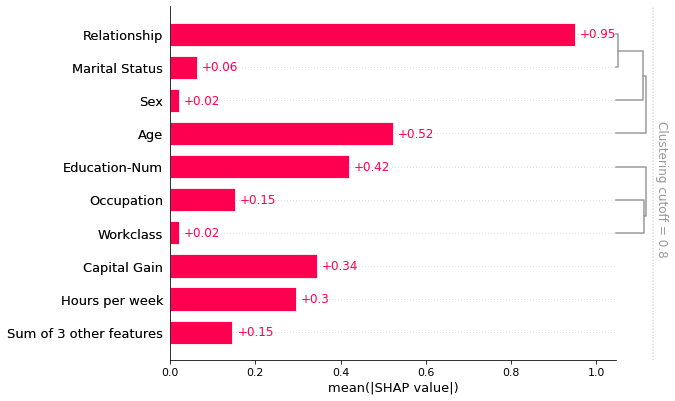

In [30]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

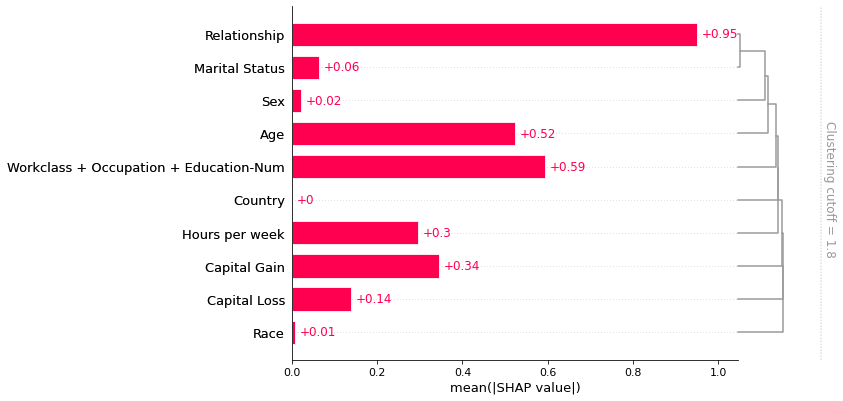

In [31]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

## (3) IMDB reviews

### Explaining a transformers NLP model
This demonstrates how SHAP can be applied to complex model types with highly structured inputs.*texte en italique*

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.6 MB/s 
     |████████████████████████████████| 895 kB 52.0 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 9.2 MB/s 
     |████████████████████████████████| 212 kB 62.3 MB/s 


In [6]:
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1)

NameError: ignored

In [ ]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

# II. Correlation is not causation

SHAP makes transparent the correlations picked up by predictive ML models. But making correlations transparent does not make them causal! All predictive models implicitly assume that everyone will keep behaving the same way in the future, and therefore correlation patterns will stay constant. To understand what happens if someone starts behaving differently, we need to build causal models, which requires making assumptions and using the tools of causal analysis.



## A subscriber retention example

Imagine we are tasked with building a model that predicts whether a customer will renew their product subscription. Let’s assume that after a bit of digging we manage to get eight features which are important for predicting churn: customer discount, ad spending, customer’s monthly usage, last upgrade, bugs reported by a customer, interactions with a customer, sales calls with a customer, and macroeconomic activity. We then use those features to train a basic XGBoost model to predict if a customer will renew their subscription when it expires:

In [7]:
# This cell defines the functions we use to generate the data in our scenario

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost

class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

# generate the data
def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

In [8]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

Once we have our XGBoost customer retention model in hand, we can begin exploring what it has learned with an interpretability tool like SHAP. We start by plotting the global importance of each feature in the model:

[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

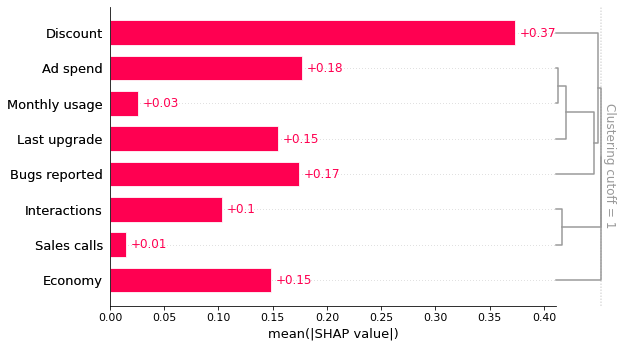

In [9]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

This bar plot shows that the discount offered, ad spend, and number of bugs reported are the top three factors driving the model’s prediction of customer retention. This is interesting and at first glance looks reasonable. The bar plot also includes a feature redundancy clustering which we will use later.

## Prediction tasks versus causal tasks

However, when we dig deeper and look at how changing the value of each feature impacts the model’s prediction, we find some unintuitive patterns. SHAP scatter plots show how changing the value of a feature impacts the model’s prediction of renewal probabilities. If the blue dots follow an increasing pattern, this means that the larger the feature, the higher is the model’s predicted renewal probability.

The scatter plots show some surprising findings: 
- Users who report more bugs are more likely to renew! 
- Users with larger discounts are less likely to renew!

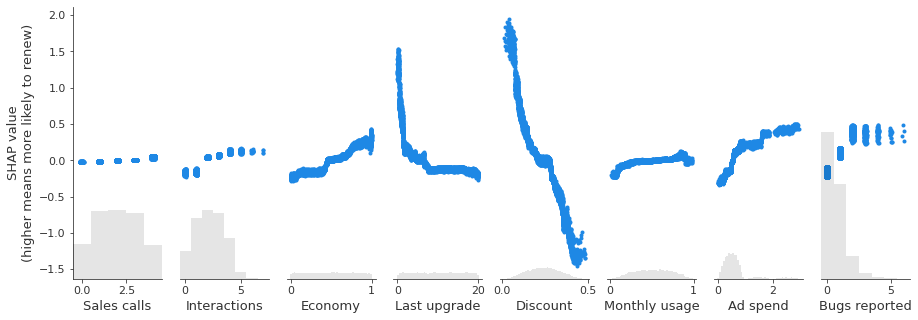

In [10]:
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")

We triple-check our code and data pipelines to rule out a bug, then talk to some business partners who offer an intuitive explanation: 
- Users with high usage who value the product are more likely to report bugs and to renew their subscriptions. 
- The sales force tends to give high discounts to customers they think are less likely to be interested in the product, and these customers have higher churn.

Are these at-first counter-intuitive relationships in the model a problem? That depends on what our goal is!

Our original goal for this model was to predict customer retention, which is useful for projects like estimating future revenue for financial planning. Since users reporting more bugs are in fact more likely to renew, capturing this relationship in the model is helpful for prediction. As long as our model has good fit out-of-sample, we should be able to provide finance with a good prediction, and therefore shouldn’t worry about the direction of this relationship in the model.

This is an example of a class of tasks called prediction tasks. In a prediction task, the goal is to predict an outcome Y (e.g. renewals) given a set of features X. A key component of a prediction exercise is that we only care that the prediction model(X) is close to Y in data distributions similar to our training set. A simple correlation between X and Y can be helpful for these types of predictions.

However, suppose a second team picks up our prediction model with the new goal of determining what actions our company can take to retain more customers. This team cares a lot about how each X feature relates to Y, not just in our training distribution, but the counterfactual scenario produced when the world changes. In that use case, it is no longer sufficient to identify a stable correlation between variables; this team wants to know whether manipulating feature X will cause a change in Y. Picture the face of the chief of engineering when you tell him that you want him to introduce new bugs to increase customer renewals!

This is an example of a class of tasks called causal tasks. In a causal task, we want to know how changing an aspect of the world X (e.g bugs reported) affects an outcome Y (renewals). In this case, it’s critical to know whether changing X causes an increase in Y, or whether the relationship in the data is merely correlational.

## The challenges of estimating causal effects

A useful tool to understanding causal relationships is writing down a causal graph of the data generating process we’re interested in. A causal graph of our example illustrates why the robust predictive relationships picked up by our XGBoost customer retention model differ from the causal relationships of interest to the team that wants to plan interventions to increase retention. This graph is just a summary of the true data generating mechanism (which is defined above). Solid ovals represent features that we observe, while dashed ovals represent hidden features that we don’t measure. Each feature is a function of all the features with an arrow to it, plus some random effects.

In our example we know the causal graph because we simulate the data. In practice the true causal graph will not be known, but we may be able to use context-specific domain knowledge about how the world works to infer which relationships can or cannot exist.

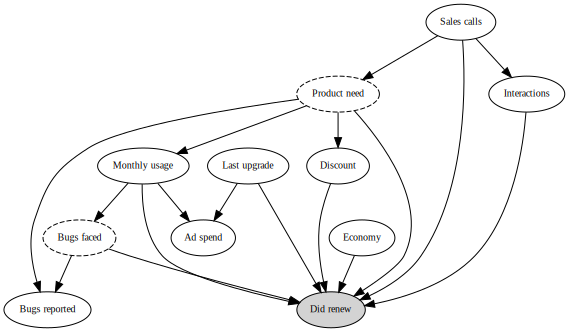

In [11]:
import graphviz
names = [
         "Bugs reported", "Monthly usage", "Sales calls", "Economy",
         "Discount", "Last upgrade", "Ad spend", "Interactions"
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")
g

There are lots of relationships in this graph, but the first important concern is that some of the features we can measure are influenced by unmeasured confounding features like product need and bugs faced. For example, users who report more bugs are encountering more bugs because they use the product more, and they are also more likely to report those bugs because they need the product more. Product need has its own direct causal effect on renewal. Because we can’t directly measure product need, the correlation we end up capturing in predictive models between bugs reported and renewal combines a small negative direct effect of bugs faced and a large positive confounding effect from product need. The figure below plots the SHAP values in our example against the true causal effect of each feature (known in this example since we generated the data).

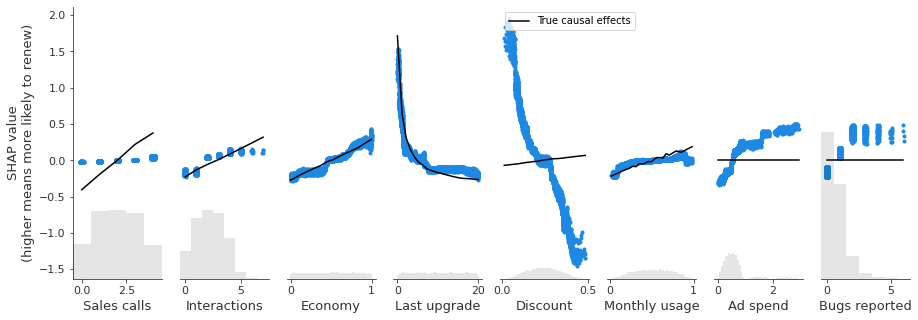

In [12]:
def marginal_effects(generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0):
    """ Helper function to compute the true marginal causal effects.
    """
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i,c in enumerate(columns):
        xs[i] = np.unique([np.nanpercentile(xs[i], v, interpolation='nearest') for v in np.linspace(0, 100, max_points)])
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)", overlay={
    "True causal effects": marginal_effects(generator, 10000, X.columns)
})

The predictive model captures an overall positive effect of bugs reported on retention (as shown with SHAP), even though the causal effect of reporting a bug is zero, and the effect of encoutering a bug is negative.

We see a similar problem with Discounts, which are also driven by unobserved customer need for the product. Our predictive model finds a negative relationship between discounts and retention, driven by this correlation with the unobserved feature, Product Need, even though there is actually a small positive causal effect of discounts on renewal! Put another way, if two customers with have the same Product Need and are otherwise similar, then the customer with the larger discount is more likely to renew.

This plot also reveals a second, sneakier problem when we start to interpret predictive models as if they were causal. Notice that Ad Spend has a similar problem - it has no causal effect on retention (the black line is flat), but the predictive model is picking up a positive effect!

In this case, Ad Spend is only driven by Last Upgrade and Monthly Usage, so we don’t have an unobserved confounding problem, instead we have an observed confounding problem. There is statistical redundancy between Ad Spend and features that influence Ad Spend. When we have the same information captured by several features, predictive models can use any of those features for prediction, even though they are not all causal. While Ad Spend has no causal effect on renewal itself, it is strongly correlated with several features that do drive renewal. Our regularized model identifies Ad Spend as a useful predictor because it summarizes multiple causal drivers (so leading to a sparser model), but that becomes seriously misleading if we start to interpret it as a causal effect.

We will now tackle each piece of our example in turn to illustrate when predictive models can accurately measure causal effects, and when they cannot. We will also introduce some causal tools that can sometimes estimate causal effects in cases where predictive models fail.

## When predictive models can answer causal questions

Let’s start with the successes in our example. Notice that our predictive model does a good job of capturing the real causal effect of the Economy feature (a better economy has a positive effect on retention). So when can we expect predictive models to capture true causal effects?

The important ingredient that allowed XGBoost to **get a good causal effect estimate** for Economy is **the feature’s strong independent component** (in this simulation); its predictive power for retention is not strongly redundant with any other measured features, or with any unmeasured confounders. In consequence, it is not subject to bias from either unmeasured confounders or feature redundancy.

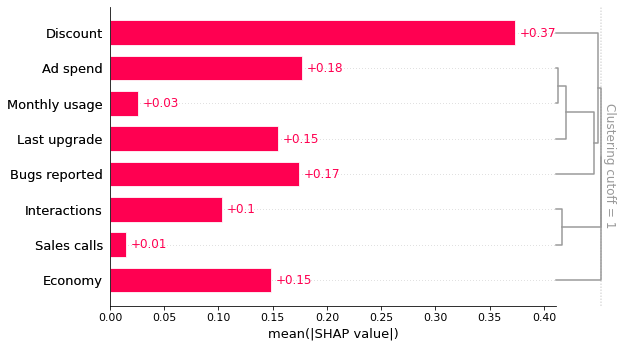

In [13]:
# Economy is independent of other measured features.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

Since we have added clustering to the right side of the SHAP bar plot we can see the redundancy structure of our data as a dendrogram. **When features merge together at the bottom (left) of the dendrogram it means that that the information those features contain about the outcome (renewal) is very redundant and the model could have used either feature**. When features merge together at the top (right) of the dendrogram it means the information they contain about the outcome is independent from each other.

We can see that Economy is **independent from all the other measured features by noting that Economy does not merge with any other features until the very top of the clustering dendrogram**. This tells us that Economy **does not suffer from observed confounding**. But to trust that the Economy effect is causal we also need to check for unobserved confounding. Checking for unmeasured confounders is harder and requires using domain knowledge (provided by the business partners in our example above).

For classic predictive ML models to deliver causal results the features need to be independent not only of other features in the model, but also of unobserved confounders. It’s not common to find examples of drivers of interest that exhibit this level of independence naturally, but we can often find examples of independent features when our data contains some experiments.

## When predictive models cannot answer causal questions but causal inference methods can help

In most real-world datasets features are not independent and unconfounded, **so standard predictive models will not learn the true causal effects**. As a result, explaining them with **SHAP will not reveal causal effects**. But all is not lost, sometimes we can fix or at least minimize this problem using the tools of observational causal inference.

### Observed confounding
The first scenario where causal inference can help is observed confounding. A feature is “confounded” when there is another feature that causally affects both the original feature and the outcome we are predicting. If we can measure that other feature it is called an observed confounder.

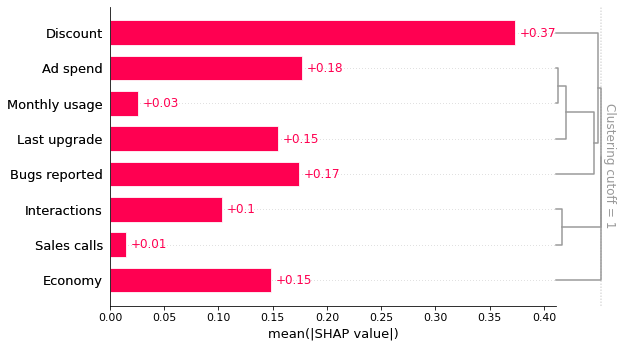

In [14]:
# Ad spend is very redundant with Monthly usage and Last upgrade.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

An example of this in our scenario is the Ad Spend feature. Even though Ad Spend has no direct causal effect on retention, it is correlated with the Last Upgrade and Monthly Usage features, which do drive retention. Our predictive model identifies Ad Spend as the one of the best single predictors of retention because it captures so many of the true causal drivers through correlations. **XGBoost imposes regularization, which is a fancy way of saying that it tries to choose the simplest possible model that still predicts well. If it could predict equally well using one feature rather than three, it will tend to do that to avoid overfitting. But this means that if Ad Spend is highly correlated with both Last Upgrade and Monthly Usage, XGBoost may use Ad Spend instead of the causal features! This property of XGBoost (or any other machine learning model with regularization) is very useful for generating robust predictions of future retention, but not good for understanding which features we should manipulate if we want to increase retention.**

This highlights the importance of matching the right modeling tools to each question. Unlike the bug reporting example, there is nothing intuitively wrong with the conclusion that increasing ad spend increases retention. Without proper attention to what our predictive model is, and is not, measuring, we could easily have proceeded with this finding and only learned our mistake after increasing spending on advertising and not getting the renewal results we expected.

### Observational Causal Inference

The good news for Ad Spend is that we can measure all the features that could confound it (those features with arrows into Ad Spend in our causal graph above). Therefore, this is an example of observed confounding, and we should be able to disentangle the correlation patterns using only the data we’ve already collected; we just need to use the right tools from observational causal inference. These tools allow us to specify what features could confound Ad Spend and then adjust for those features, to get an unconfounded estimate of the causal effect of Ad Spend on product renewal.

One particularly flexible tool for observational causal inference is **double/debiased machine learning**. It uses any machine learning model you want to first deconfound the feature of interest (i.e. Ad Spend) and then estimate the average causal effect of changing that feature (i.e. the average slope of the causal effect).

Double ML works as follows: 

1. Train a model to predict a feature of interest (i.e. Ad Spend) using a set of possible confounders (i.e. any features not caused by Ad Spend). 
2. Train a model to predict the outcome (i.e. Did Renew) using the same set of possible confounders. 
3. Train a model to predict the residual variation of the outcome (the variation left after subtracting our prediction) using the residual variation of the causal feature of interest.

**The intuition is that if Ad Spend causes renewal, then the part of Ad Spend that can’t be predicted by other confounding features should be correlated with the part of renewal that can’t be predicted by other confounding features.** Stated another way, double ML assumes that there is an independent (unobserved) noise feature that impacts Ad Spend (since Ad Spend is not perfectly determined by the other features), so we can impute the value of this independent noise feature and then train a model on this independent feature to predict the output.

While we could do all the double ML steps manually, it is easier to use a **causal inference package like econML or CausalML**. Here we use econML’s LinearDML model. This returns a P-value of whether that treatment has a non-zero causal effect, and works beautifully in our scenario, correctly identifying that there is no evidence for a causal effect of ad spending on renewal (P-value = 0.85):

In [16]:
!pip install econml

     |████████████████████████████████| 3.3 MB 6.9 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 356 kB 13.6 MB/s 
     |████████████████████████████████| 123 kB 12.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491667 sha256=23c5ec45a660870e7abc3c491d80cecf2ab8bb827575f492543b10b7c1de9d6e
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
  Attempting uninstall: shap
    Found existing installation: shap 0.40.0
    Uninstalling shap-0.40.0:
      Successfully uninstalled shap-0.40.0


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.


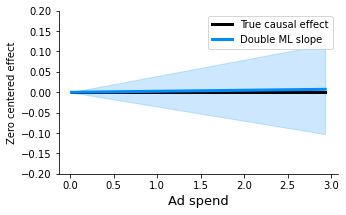

In [17]:
from econml.dml import LinearDML
from sklearn.base import BaseEstimator, clone
import matplotlib.pyplot as plt

class RegressionWrapper(BaseEstimator):
    """ Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """
    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]

# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features):
    """ Use doubleML from econML to estimate the slope of the causal effect of a feature.
    """
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.effect_inference()

def plot_effect(effect, xs, true_ys, ylim=None):
    """ Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max())/2
    pred_ys = [effect.pred[0]*(xs.min() - mid), effect.pred[0]*(xs.max() - mid)]

    plt.plot(xs, true_ys - true_ys[0], label='True causal effect', color="black", linewidth=3)
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(pred_xs, point_pred - point_pred[0], label='Double ML slope', color=shap.plots.colors.blue_rgb, linewidth=3)
    # 99.9% CI
    plt.fill_between(pred_xs, point_pred - point_pred[0] - 3.291 * pred_stderr,
                     point_pred - point_pred[0] + 3.291 * pred_stderr, alpha=.2, color=shap.plots.colors.blue_rgb)
    plt.legend()
    plt.xlabel("Ad spend", fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.show()

# estimate the causal effect of Ad spend controlling for all the other features
causal_feature = "Ad spend"
control_features = [
    "Sales calls", "Interactions", "Economy", "Last upgrade", "Discount",
    "Monthly usage", "Bugs reported"
]
effect = double_ml(y, X[causal_feature], X.loc[:,control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[["Ad spend"]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.2, 0.2))

**Remember, double ML (or any other observational causal inference method) only works when you can measure and identify all the possible confounders of the feature for which you want to estimate causal effects**. Here we know the causal graph and can see that Monthly Usage and Last Upgrade are the two direct confounders we need to control for. But **if we didn’t know the causal graph we could still look at the redundancy in the SHAP bar plot** and see that Monthly Usage and Last Upgrade are **the most redundant features** and so are good candidates to control for (as are Discounts and Bugs Reported).

### Non-confounding redundancy

The second scenario where causal inference can help is non-confounding redundancy. This occurs when the feature we want causal effects for causally drives, or is driven by, another feature included in the model, but that other feature is not a confounder of our feature of interest.

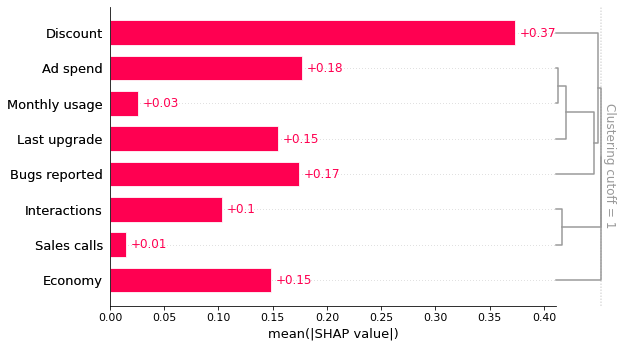

In [18]:
# Interactions and sales calls are very redundant with one another.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

An example of this is the Sales Calls feature. Sales Calls directly impact retention, but also have an indirect effect on retention through Interactions. When we include both the Interactions and Sales Calls features in the model the causal effect shared by both features is forced to spread out between them. We can see this in the SHAP scatter plots above, which show how XGBoost underestimates the true causal effect of Sales Calls because most of that effect got put onto the Interactions feature.

Non-confounding redundancy can be fixed in principle by removing the redundant variables from the model (see below). For example, if we removed Interactions from the model then we will capture the full effect of making a sales call on renewal probability. This removal is also important for double ML, since double ML will fail to capture indirect causal effects if you control for downstream features caused by the feature of interest. In this case double ML will only measure the “direct” effect that does not pass through the other feature. Double ML is however robust to controlling for upstream non-confounding redundancy (where the redundant feature causes the feature of interest), though this will reduce your statistical power to detect true effects.

**Unfortunately, we often don’t know the true causal graph so it can be hard to know when another feature is redundant with our feature of interest because of observed confounding vs. non-confounding redundancy**. If it is because of confounding then we should control for that feature using a method like double ML, whereas if it is a downstream consequence then we should drop the feature from our model if we want full causal effects rather than only direct effects. Controlling for a feature we shouldn’t tend to hide or split up causal effects, while failing to control for a feature we should have controlled for tends to infer causal effects that do not exist. This generally makes controlling for a feature the safer option when you are uncertain.

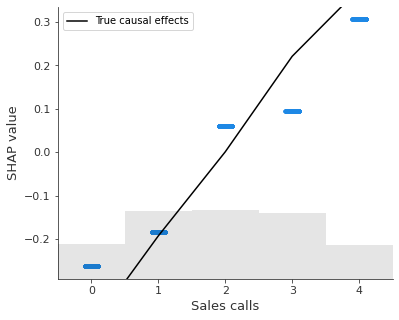

In [19]:
# Fit, explain, and plot a univariate model with just Sales calls
# Note how this model does not have to split of credit between Sales calls and
# Interactions, so we get a better agreement with the true causal effect.
sales_calls_model = fit_xgboost(X[["Sales calls"]], y)
sales_calls_shap_values = shap.Explainer(sales_calls_model)(X[["Sales calls"]])
shap.plots.scatter(sales_calls_shap_values, overlay={
    "True causal effects": marginal_effects(generator, 10000, ["Sales calls"])
})

## When neither predictive models nor unconfounding methods can answer causal questions

Double ML (or any other causal inference method that assumes unconfoundedness) only works when you can measure and identify all the possible confounders of the feature for which you want to estimate causal effects. If you can’t measure all the confounders then you are in the hardest possible scenario: unobserved confounding.

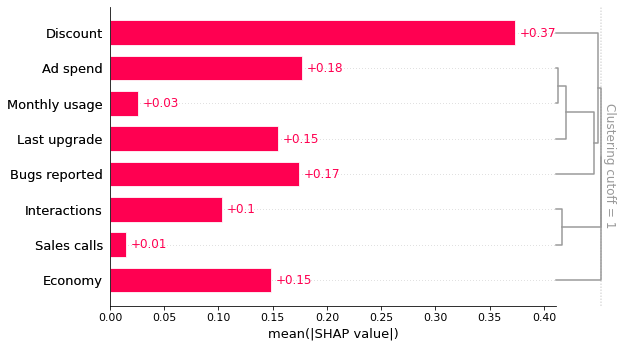

In [20]:
# Discount and Bugs reported seem are fairly independent of the other features we can
# measure, but they are not independent of Product need, which is an unobserved confounder.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

The Discount and Bugs Reported features both suffer from unobserved confounding because not all important variables (e.g., Product Need and Bugs Faced) are measured in the data. Even though both features are relatively independent of all the other features in the model, there are important drivers that are unmeasured. In this case, both predictive models and causal models that require confounders to be observed, like double ML, will fail. This is why double ML estimates a large negative causal effect for the Discount feature even when controlling for all other observed features:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.


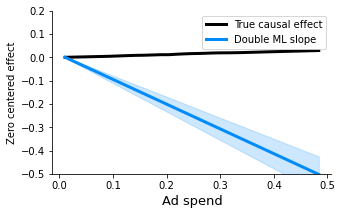

In [21]:
# estimate the causal effect of Ad spend controlling for all the other features
causal_feature = "Discount"
control_features = [
    "Sales calls", "Interactions", "Economy", "Last upgrade",
    "Monthly usage", "Ad spend", "Bugs reported"
]
effect = double_ml(y, X[causal_feature], X.loc[:,control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.5, 0.2))

Barring the ability to measure the previously unmeasured features (or features correlated with them), finding causal effects in the presence of unobserved confounding is difficult. In these situations, **the only way to identify causal effects that can inform policy is to create or exploit some randomization that breaks the correlation between the features of interest and the unmeasured confounders. Randomized experiments remain the gold standard for finding causal effects in this context**.

Specialized causal tools based on the principals of instrumental variables, differences-in-differences, or regression discontinuities can sometimes exploit partial randomization even in cases where a full experiment is impossible. For example, instrumental variable techniques can be used to identify causal effects in cases where we cannot randomly assign a treatment, but we can randomly nudge some customers towards treatment, like sending an email encouraging them to explore a new product feature. Difference-in-difference approaches can be helpful when the introduction of new treatments is staggered across groups. Finally, regression discontinuity approaches are a good option when patterns of treatment exhibit sharp cut-offs (for example qualification for treatment based on a specific, measurable trait like revenue over $5,000 per month).

## Summary
Flexible predictive models like XGBoost or LightGBM are powerful tools for solving prediction problems. However, they are not inherently causal models, so interpreting them with SHAP will fail to accurately answer causal questions in many common situations. Unless features in a model are the result of experimental variation, applying SHAP to predictive models without considering confounding is generally not an appropriate tool to measure causal impacts used to inform policy. SHAP and other interpretability tools can be useful for causal inference, and SHAP is integrated into many causal inference packages, but those use cases are explicitly causal in nature. To that end, using the same data we would collect for prediction problems and using causal inference methods like double ML that are particularly designed to return causal effects is often a good approach for informing policy. In other situations, only an experiment or other source of randomization can really answer what if questions. Causal inference always requires us to make important assumptions. The main point of this article is that the assumptions we make by interpreting a normal predictive model as causal are often unrealistic.

# III. Explaining quantitative measures of fairness

This hands-on article connects explainable AI methods with fairness measures and shows how modern explainability methods can enhance the usefulness of quantitative fairness metrics. By using SHAP (a popular explainable AI tool) we can decompose measures of fairness and allocate responsibility for any observed disparity among each of the model’s input features. Explaining these quantitative fairness metrics can reduce the concerning tendency to rely on them as opaque standards of fairness, and instead promote their informed use as tools for understanding how model behavior differs between groups.

Quantitative fairness metrics seek to bring mathematical precision to the definition of fairness in machine learning [1]. Definitions of fairness however are deeply rooted in human ethical principles, and so on value judgements that often depend critically on the context in which a machine learning model is being used. This practical dependence on value judgements manifests itself in the mathematics of quantitative fairness measures as a set of trade-offs between sometimes mutually incompatible definitions of fairness [2]. Since fairness relies on context-dependent value judgements it is dangerous to treat quantitative fairness metrics as opaque black-box measures of fairness, since doing so may obscure important value judgment choices.

## How SHAP can be used to explain various measures of model fairness

This article is not about how to choose the “correct” measure of model fairness, but rather about explaining whichever metric you have chosen. Which fairness metric is most appropriate depends on the specifics of your context, such as what laws apply, how the output of the machine learning model impacts people, and what value you place on various outcomes and hence tradeoffs. Here we will use the classic demographic parity metric, since it is simple and closely connected to the legal notion of disparate impact. The same analysis can also be applied to other metrics such as decision theory cost, equalized odds, equal opportunity, or equal quality of service. Demographic parity states that the output of the machine learning model should be equal between two or more groups. The demographic parity difference is then a measure of how much disparity there is between model outcomes in two groups of samples.

**Since SHAP decomposes the model output into feature attributions with the same units as the original model output, we can first decompose the model output among each of the input features using SHAP, and then compute the demographic parity difference (or any other fairness metric) for each input feature seperately using the SHAP value for that feature.** Because the SHAP values sum up to the model’s output, the sum of the demographic parity differences of the SHAP values also sum up to the demographic parity difference of the whole model.

## What SHAP fairness explanations look like in various simulated scenarios

To help us explore the potential usefulness of explaining quantitative fairness metrics we consider a simple simulated scenario based on credit underwriting. In our simulation there are four underlying factors that drive the risk of default for a loan: income stability, income amount, spending restraint, and consistency. These underlying factors are not observed, but they variously influence four different observable features: job history, reported income, credit inquiries, and late payments. Using this simulation we generate random samples and then train a non-linear XGBoost classifier to predict the probability of default. The same process also works for any other model type supported by SHAP, just remember that explanations of more complicated models hide more of the model’s details.

By introducing sex-specific reporting errors into a fully specified simulation we can observe how the biases caused by these errors are captured by our chosen fairness metric. In our simulated case the true labels (will default on a loan) are statistically independent of sex (the sensitive class we use to check for fairness). So any disparity between men and women means one or both groups are being modeled incorrectly due to feature measurement errors, labeling errors, or model errors. If the true labels you are predicting (which might be different than the training labels you have access to) are not statistically independent of the sensitive feature you are considering, then even a perfect model with no errors would fail demographic parity. In these cases fairness explanations can help you determine which sources of demographic disparity are valid.

In [22]:
# here we define a function that we can call to execute our simulation under
# a variety of different alternative scenarios
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import shap
%config InlineBackend.figure_format = 'retina'
def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0, income_sex_impact=0,
                          late_payments_sex_impact=0, default_rate_sex_impact=0,
                          include_brandx_purchase_score=False, include_sex=False):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1 # randomly half men and half women

    # four hypothetical causal factors influence customer quality
    # they are all scaled to the same units between 0-1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    if income_sex_impact > 0:
        income_amount -= income_sex_impact/90000 * sex * np.random.rand(N)
        income_amount -= income_amount.min()
        income_amount /= income_amount.max()
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)

    # intuitively this product says that high customer quality comes from simultaneously
    # being strong in all factors
    customer_quality = income_stability * income_amount * spending_restraint * consistency

    # job history is a random function of the underlying income stability feature
    job_history = np.maximum(
        10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N)
    , 0)

    # reported income is a random function of the underlying income amount feature
    reported_income =  np.maximum(
        10000 + 90000*income_amount + np.random.randn(N) * 10000 - \
        reported_income_sex_impact * sex * np.random.rand(N)
    , 0)

    # credit inquiries is a random function of the underlying spending restraint and income amount features
    credit_inquiries = np.round(6 * np.maximum(-spending_restraint + income_amount, 0)) + \
                       np.round(np.random.rand(N) > 0.1)

    # credit inquiries is a random function of the underlying consistency and income stability features
    late_payments = np.maximum(
        np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + \
        np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N))
    , 0)

    # bundle everything into a data frame and define the labels based on the default rate and customer quality
    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    })
    default_rate = 0.40 + sex * default_rate_sex_impact
    y = customer_quality < np.percentile(customer_quality, default_rate * 100)

    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score

    if include_sex:
        X["Sex"] = sex + 0

    # build model
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05)
    model.fit(X, y)

    # build explanation
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)

    return shap_values, sex, X, explainer.expected_value

## Scenario A: No reporting errors
Our first experiment is a simple baseline check where we refrain from introducing any sex-specific reporting errors. While we could use any model output to measure demographic parity, we use the continuous log-odds score from a binary XGBoost classifier. As expected, this baseline experiment results in no significant demographic parity difference between the credit scores of men and women. We can see this by plotting the difference between the average credit score for women and men as a bar plot and noting that zero is close to the margin of error (note that negative values mean women have a lower average predicted risk than men, and positive values mean that women have a higher average predicted risk than men):

 94%|=================== | 9410/10000 [00:14<00:00]       

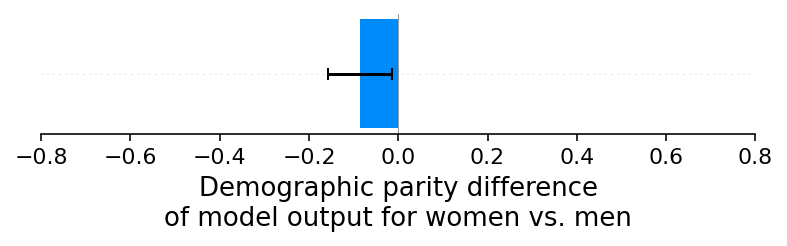

In [23]:
N = 10000
shap_values_A, sex_A, X_A, ev_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(shap_values_A.sum(1), sex_A, xmin=xmin, xmax=xmax, xlabel=glabel)

Now we can use SHAP to decompose the model output among each of the model’s input features and then compute the demographic parity difference on the component attributed to each feature. As noted above, because the SHAP values sum up to the model’s output, the sum of the demographic parity differences of the SHAP values for each feature sum up to the demographic parity difference of the whole model. This means that the sum of the bars below equals the bar above (the demographic parity difference of our baseline scenario model).

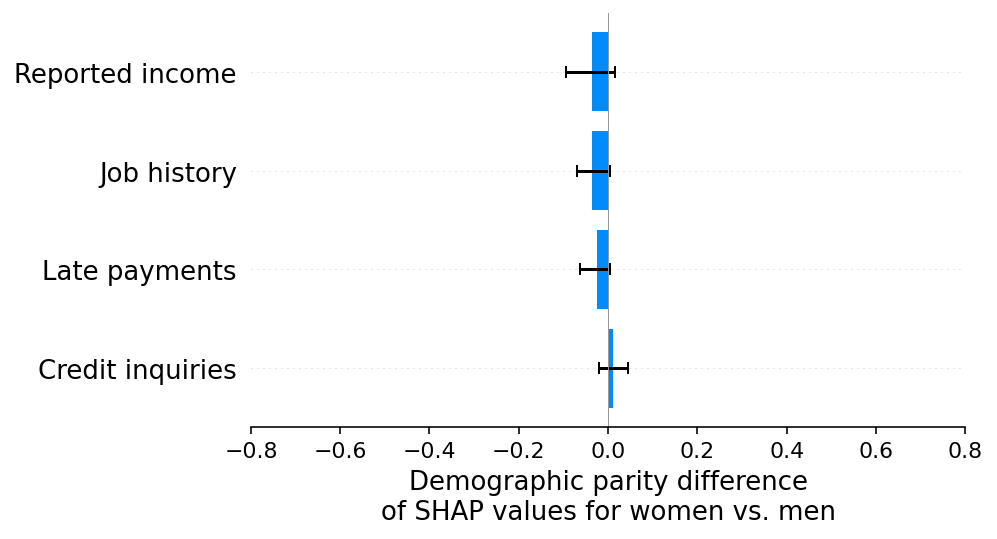

In [24]:
slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_A, sex_A, X_A.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## Scenario B: An under-reporting bias for women’s income
In our baseline scenario we designed a simulation where sex had no impact on any of the features or labels used by the model. Here in scenario B we introduce an under-reporting bias for women’s income into the simulation. The point here is not how realistic it would be for women’s income to be under-reported in the real-world, but rather how we can identify that a sex-specific bias has been introduced and understand where it came from. By plotting the difference in average model output (default risk) between women and men we can see that the income under-reporting bias has created a significant demographic parity difference where women now have a higher risk of default than men:

 98%|===================| 9816/10000 [00:15<00:00]       

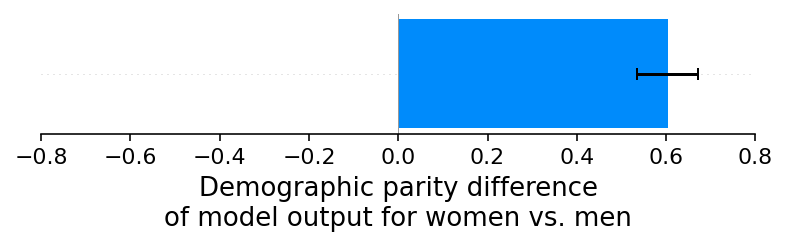

In [25]:
shap_values_B, sex_B, X_B, ev_B = run_credit_experiment(N, reported_income_sex_impact=30000)
model_outputs_B = ev_B + shap_values_B.sum(1)
shap.group_difference_plot(shap_values_B.sum(1), sex_B, xmin=xmin, xmax=xmax, xlabel=glabel)

If this were a real application, this demographic parity difference might trigger an in-depth analysis of the model to determine what might be causing the disparity. While this investigation is challenging given just a single demographic parity difference value, it is much easier given the per-feature demographic parity decomposition based on SHAP. Using SHAP we can see there is a significant bias coming from the reported income feature that is increasing the risk of women disproportionately to men. This allows us to quickly identify which feature has the reporting bias that is causing our model to violate demographic parity:

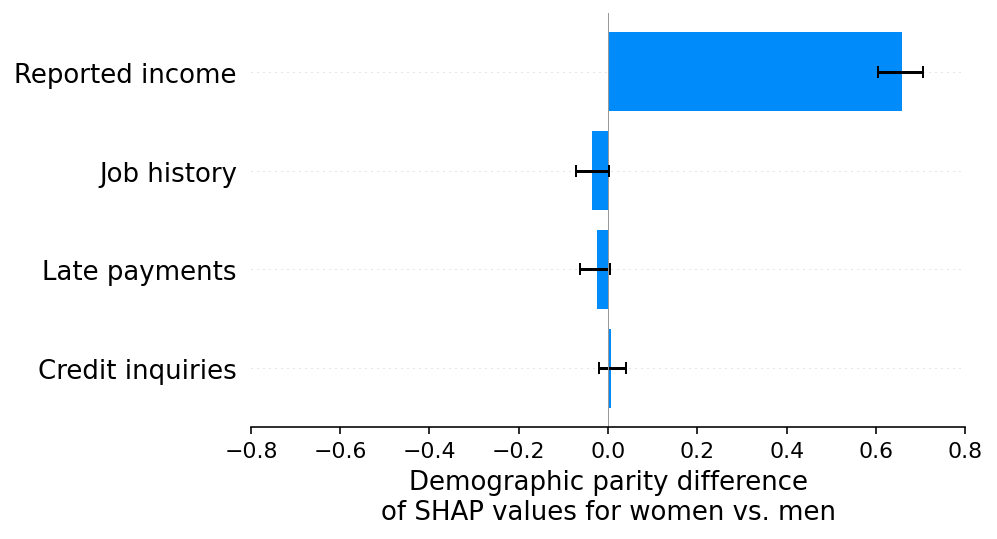

In [26]:
shap.group_difference_plot(shap_values_B, sex_B, X_B.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

It is important to note at this point how our assumptions can impact the interpretation of SHAP fairness explanations. In our simulated scenario we know that women actually have identical income profiles to men, so when we see that the reported income feature is biased lower for women than for men, we know that has come from a bias in the measurement errors in the reported income feature. The best way to address this problem would be figure out how to debias the measurement errors in the reported income feature. Doing so would create a more accurate model that also has less demographic disparity. However, if we instead assume that women actually are making less money than men (and it is not just a reporting error), then we can’t just “fix” the reported income feature. Instead we have to carefully consider how best to account for real differences in default risk between two protected groups. It is impossible to determine which of these two situations is happening using just the SHAP fairness explanation, since in both cases the reported income feature will be responsible for an observed disparity between the predicted risks of men and women.

## Scenario C: An under-reporting bias for women’s late payments
To verify that SHAP demographic parity explanations can correctly detect disparities regardless of the direction of effect or source feature, we repeat our previous experiment but instead of an under-reporting bias for income, we introduce an under-reporting bias for women’s late payment rates. This results in a significant demographic parity difference for the model’s output where now women have a lower average default risk than men:

 95%|=================== | 9503/10000 [00:18<00:00]       

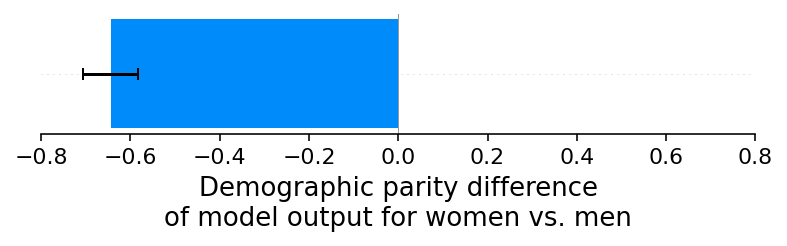

In [27]:
shap_values_C, sex_C, X_C, ev_C = run_credit_experiment(N, late_payments_sex_impact=2)
model_outputs_C = ev_C + shap_values_C.sum(1)
shap.group_difference_plot(shap_values_C.sum(1), sex_C, xmin=xmin, xmax=xmax, xlabel=glabel)

And as we would hope, the SHAP explanations correctly highlight the late payments feature as the cause of the model’s demographic parity difference, as well as the direction of the effect:

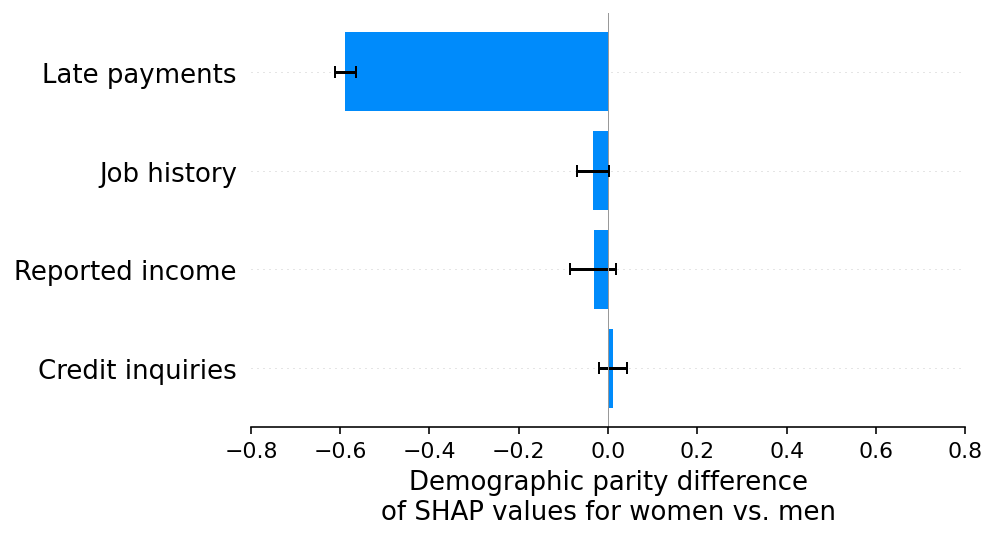

In [28]:
shap.group_difference_plot(shap_values_C, sex_C, X_C.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## Scenario D: An under-reporting bias for women’s default rates
The experiments above focused on introducing reporting errors for specific input features. Next we consider what happens when we introduce reporting errors on the training labels through an under-reporting bias on women’s default rates (which means defaults are less likely to be reported for women than men). Interestingly, for our simulated scenario this results in no significant demographic parity differences in the model’s output:

 97%|=================== | 9672/10000 [00:17<00:00]       

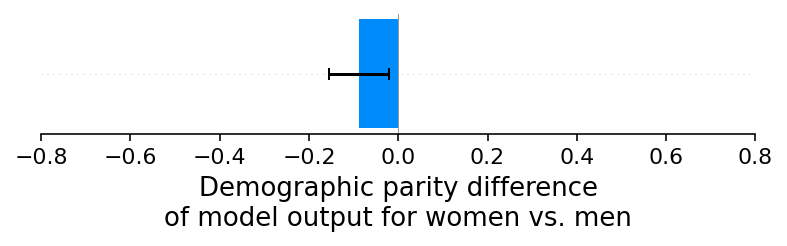

In [29]:
shap_values_D, sex_D, X_D, ev_D = run_credit_experiment(N, default_rate_sex_impact=-0.1) # 20% change
model_outputs_D = ev_D + shap_values_D.sum(1)
shap.group_difference_plot(shap_values_D.sum(1), sex_D, xmin=xmin, xmax=xmax, xlabel=glabel)

We also see no evidence of any demographic parity differences in the SHAP explanations:

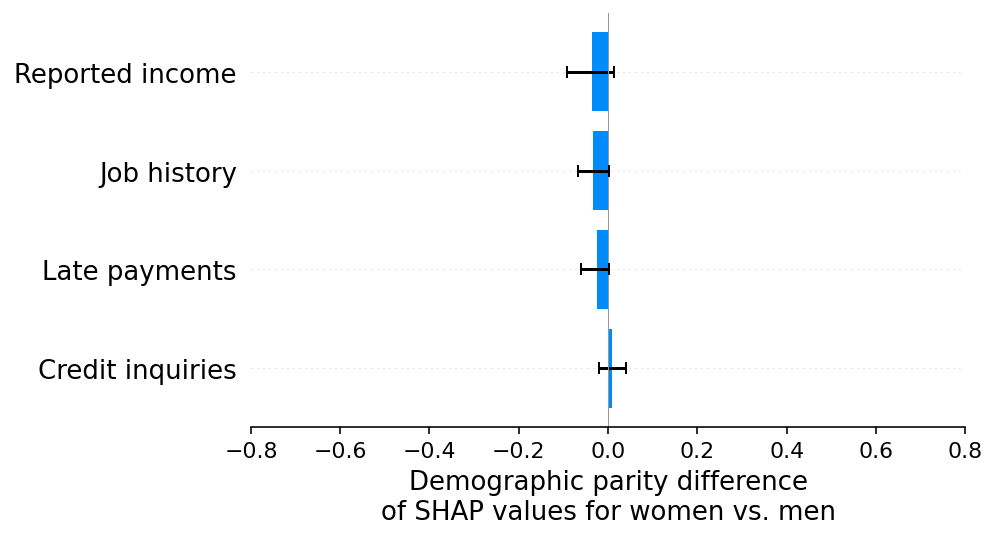

In [30]:
shap.group_difference_plot(shap_values_D, sex_D, X_D.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## Scenario E: An under-reporting bias for women’s default rates, take 2

It may at first be surprising that no demographic parity differences were caused when we introduced an under-reporting bias on women’s default rates. This is because none of the four features in our simulation are significantly correlated with sex, so none of them could be effectively used to model the bias we introduced into the training labels. If we now instead provide a new feature (brand X purchase score) to the model that is correlated with sex, then we see a demographic parity difference emerge as that feature is used by the model to capture the sex-specific bias in the training labels:

 95%|=================== | 9456/10000 [00:20<00:01]       

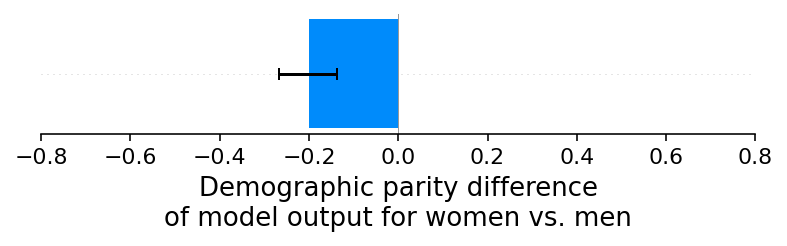

In [31]:
shap_values_E, sex_E, X_E, ev_E = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True
)
model_outputs_E = ev_E + shap_values_E.sum(1)
shap.group_difference_plot(shap_values_E.sum(1), sex_E, xmin=xmin, xmax=xmax, xlabel=glabel)

When we explain the demographic parity difference with SHAP we see that, as expected, the brand X purchase score feature drives the difference. In this case it is not because we have a bias in how we measure the brand X purchase score feature, but rather because we have a bias in our training label that gets captured by any input features that are sufficiently correlated with sex:

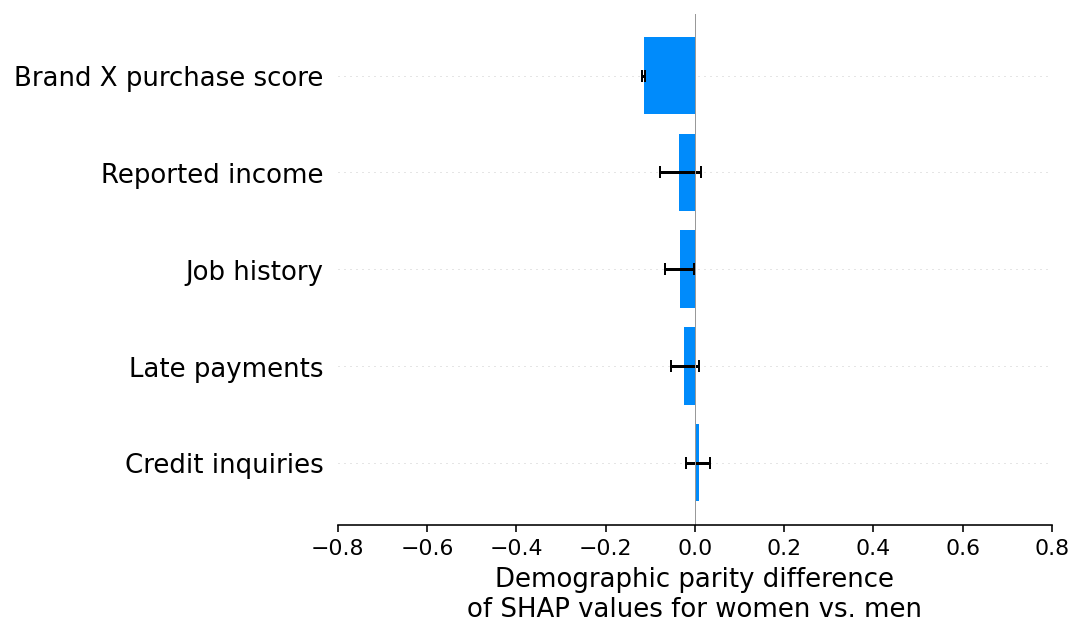

In [32]:
shap.group_difference_plot(shap_values_E, sex_E, X_E.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## Scenario F: Teasing apart multiple under-reporting biases
When there is a single cause of reporting bias then both the classic demographic parity test on the model’s output, and the SHAP explanation of the demographic parity test capture the same bias effect (though the SHAP explanation can often have more statistical significance since it isolates the feature causing the bias). But what happens when there are multiple causes of bias occurring in a dataset? In this experiment we introduce two such biases, an under-reporting of women’s default rates, and an under-reporting of women’s job history. These biases tend to offset each other in the global average and so a demographic parity test on the model’s output shows no measurable disparity:

 94%|=================== | 9360/10000 [00:14<00:00]       

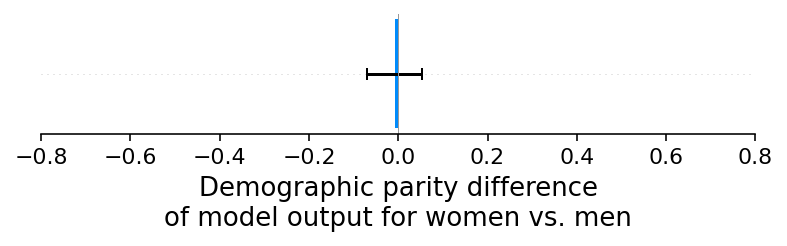

In [33]:
shap_values_F, sex_F, X_F, ev_F = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True,
    job_history_sex_impact=2
)
model_outputs_F = ev_F + shap_values_F.sum(1)
shap.group_difference_plot(shap_values_F.sum(1), sex_F, xmin=xmin, xmax=xmax, xlabel=glabel)

However, if we look at the SHAP explanation of the demographic parity difference we clearly see both (counteracting) biases:

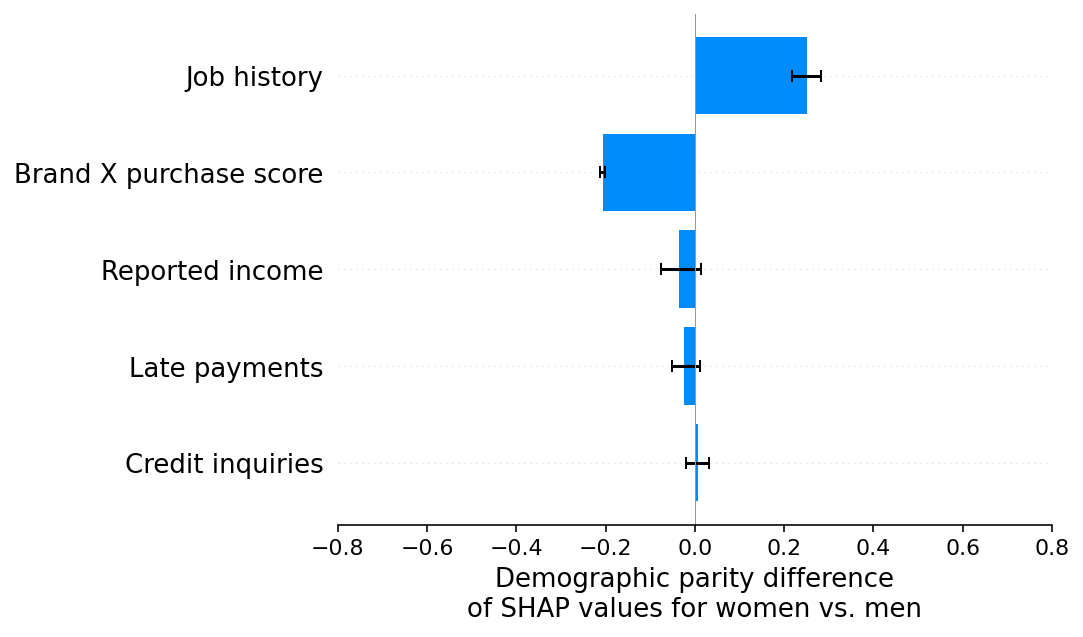

In [34]:
shap.group_difference_plot(shap_values_F, sex_F, X_F.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

Identifying multiple potentially offsetting bias effects can be important since while on average there is no disparate impact on men or women, there is disparate impact on individuals. For example, in this simulation women who have not shopped at brand X will receive a lower credit score than they should have because of the bias present in job history reporting.

## How introducing a protected feature can help distinguish between label bias and feature bias

In scenario F we were able to pick apart two distinct forms of bias, one coming from job history under-reporting and one coming from default rate under-reporting. However, the bias from default rate under-reporting was not attributed to the default rate label, but rather to the brand X purchase score feature that happened to be correlated with sex. This still leaves us with some uncertainty about the true sources of demographic parity differences, since any difference attributed to an input feature could be due to an issue with that feature, or due to an issue with the training labels.

It turns out that in this case we can help disentangle label bias from feature bias by introducing sex as a variable directly into the model. The goal of introducing sex as an input feature is to cause the label bias to fall entirely on the **sex feature**, leaving the feature biases untouched. So we can then distinguish between label biases and feature biases by comparing the results of scenario F above to our new scenario G below. **This of course creates an even stronger demographic parity difference than we had before, but that is fine since our goal here is not bias mitigation, but rather bias understanding.**

 96%|=================== | 9612/10000 [00:19<00:00]       

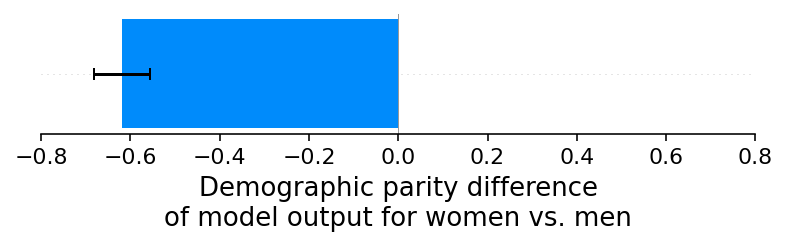

In [35]:
shap_values_G, sex_G, X_G, ev_G = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True,
    job_history_sex_impact=2, include_sex=True
)
model_outputs_G = ev_G + shap_values_G.sum(1)
shap.group_difference_plot(shap_values_G.sum(1), sex_G, xmin=xmin, xmax=xmax, xlabel=glabel)

The SHAP explanation for scenario G shows that all of the demographic parity difference that used to be attached to the brand X purchase score feature in scenario F has now moved to the sex feature, while none of the demographic parity difference attached to the job history feature in scenario F has moved. This can be interpreted to mean that all of the disparity attributed to brand X purchase score in scenario F was due to label bias, while all of the disparity attributed to job history in scenario F was due to feature bias.

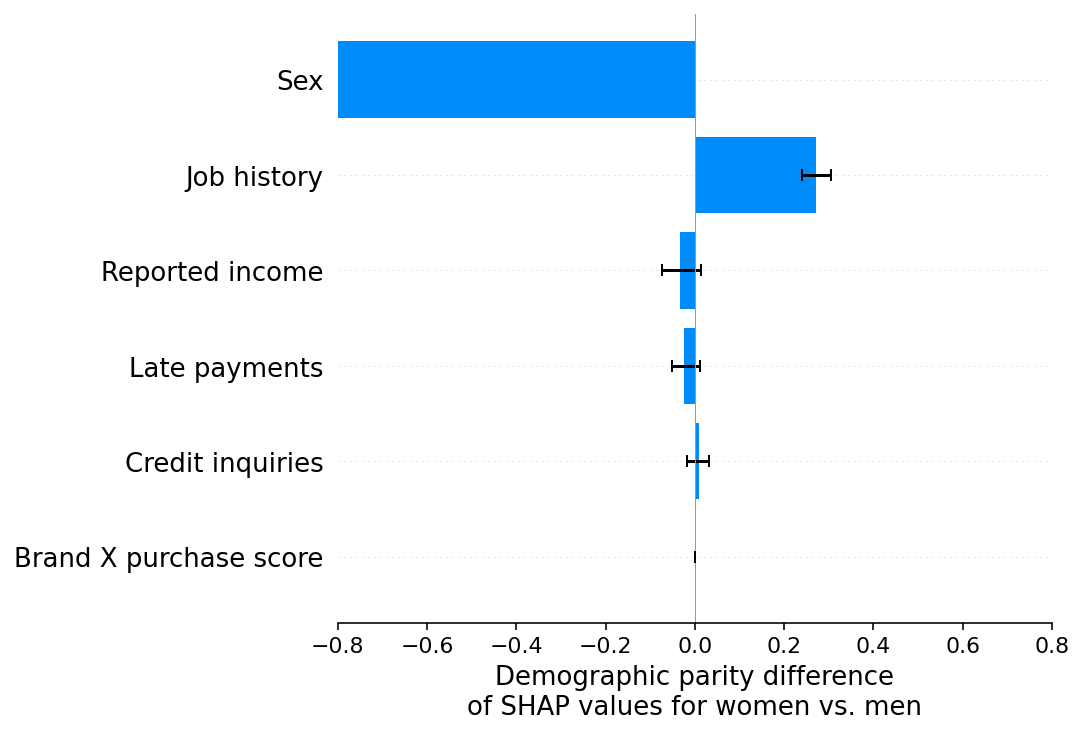

In [36]:
shap.group_difference_plot(shap_values_G, sex_G, X_G.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## Conclusion

Fairness is a complex topic where clean mathematical answers almost always come with caveats and depend on ethical value judgements. This means that it is particularly important to not just use fairness metrics as black-boxes, but rather seek to understand how these metrics are computed and what aspects of your model and training data are impacting any disparities you observe. Decomposing quantitative fairness metrics using SHAP can reduce their opacity when the metrics are driven by measurement biases effecting only a few features. I hope you find the fairness explanations we demonstrated here help you better wrestle with the underlying value judgements inherent in fairness evaluation, and so help reduce the risk of unintended consequences that comes when we use fairness metrics in real world contexts.